# Comparison of data and model

In this tutorial, the photometric fluxes of the brown dwarf companion PZ Tel B is compared with a spectrum from the AMES-Cond atmospheric model.

## Initiating *species*

In [1]:
import species

In [2]:
species.SpeciesInit()

Initiating species v0.1.4... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Adding model spectra

A `Database` object is now created which can be used for importing of data into the database.

In [3]:
database = species.Database()

The spectra of the AMES-Cond model are downloaded and added to the database. This requires sufficient disk storage in the *data_folder* that is set in the configuration file.

While the full AMES-Cond grid is downloaded, a restiction on the wavelength and T<sub>eff</sub> range can be used when the data is imported. Also the spectral resolution can be set to downsample the high-resolution of the original spectra spectra.

In [4]:
database.add_model(model='ames-cond',
                   wavel_range=(0.1, 6.),
                   spec_res=1000.,
                   teff_range=(2800., 3000.))

Unpacking AMES-Cond model spectra (823 MB)... [DONE]
Adding AMES-Cond model spectra... [DONE]                               


## Adding companion data

The distance and magnitudes of PZ Tel B are added to the database. This will automatically download the filter transmission profiles and a flux calibrated spectrum of Vega, which are used for the flux calibration.

In [5]:
database.add_companion(name='PZ Tel B')

Adding filter: Paranal/SPHERE.ZIMPOL_R_PRIM... [DONE]
Adding Vega spectrum... [DONE]
Adding filter: Paranal/SPHERE.ZIMPOL_I_PRIM... [DONE]
Adding filter: Paranal/SPHERE.IRDIS_D_H23_2... [DONE]
Adding filter: Paranal/SPHERE.IRDIS_D_H23_3... [DONE]
Adding filter: Paranal/SPHERE.IRDIS_D_K12_1... [DONE]
Adding filter: Paranal/SPHERE.IRDIS_D_K12_2... [DONE]
Adding filter: Paranal/NACO.J... [DONE]
Adding filter: Paranal/NACO.H... [DONE]
Adding filter: Paranal/NACO.Ks... [DONE]
Adding filter: Paranal/NACO.Lp... [DONE]
Adding filter: Paranal/NACO.NB405... [DONE]
Adding filter: Paranal/NACO.Mp... [DONE]
Adding filter: Gemini/NICI.ED286... [DONE]
Adding filter: Gemini/NIRI.H2S1v2-1-G0220... [DONE]
Adding object: PZ Tel B... [DONE]


Alternatively, the `add_object` method of `Database` can be used for manually adding magnitudes and spectra of an individual object. Before coninuing, let's check the content of the database.

In [6]:
database.list_content()

Database content:
- filters: <HDF5 group "/filters" (2 members)>
	- Gemini: <HDF5 group "/filters/Gemini" (2 members)>
		- NICI.ED286: <HDF5 dataset "NICI.ED286": shape (2, 387), type "<f8">
		- NIRI.H2S1v2-1-G0220: <HDF5 dataset "NIRI.H2S1v2-1-G0220": shape (2, 129), type "<f8">
	- Paranal: <HDF5 group "/filters/Paranal" (12 members)>
		- NACO.H: <HDF5 dataset "NACO.H": shape (2, 23), type "<f8">
		- NACO.J: <HDF5 dataset "NACO.J": shape (2, 20), type "<f8">
		- NACO.Ks: <HDF5 dataset "NACO.Ks": shape (2, 27), type "<f8">
		- NACO.Lp: <HDF5 dataset "NACO.Lp": shape (2, 31), type "<f8">
		- NACO.Mp: <HDF5 dataset "NACO.Mp": shape (2, 18), type "<f8">
		- NACO.NB405: <HDF5 dataset "NACO.NB405": shape (2, 67), type "<f8">
		- SPHERE.IRDIS_D_H23_2: <HDF5 dataset "SPHERE.IRDIS_D_H23_2": shape (2, 113), type "<f8">
		- SPHERE.IRDIS_D_H23_3: <HDF5 dataset "SPHERE.IRDIS_D_H23_3": shape (2, 180), type "<f8">
		- SPHERE.IRDIS_D_K12_1: <HDF5 dataset "SPHERE.IRDIS_D_K12_1": shape (2, 175), type "

## Reading model spectra

Model spectra are read from the database by creating an object of `ReadModel`. The model name and optionally a wavelength range should be provided. The wavelength range should fit within the range that was specified in `add_model`.

In [7]:
readmodel = species.ReadModel(model='ames-cond',
                              wavel_range=(0.1, 6.))

Before extracting a spectrum, let's check which parameters are required for the AMES-Cond models.

In [8]:
readmodel.get_parameters()

['teff', 'logg']

And also the grid boundaries that are stored in the database.

In [9]:
readmodel.get_bounds()

{'teff': (2800.0, 3000.0), 'logg': (0.0, 6.0)}

The parameters are provided in a dictionary. Make sure to chose values within the grid boundaries. The radius (R<sub>Jup</sub>) and distance (pc) will scale the emitted spectrum to the observer. Without these values, the spectrum is provided at the outermost layer of the atmosphere.

In [10]:
model_param = {'teff': 2900., 'logg': 4.5, 'radius': 2.2, 'distance': 47.13}

The grid of spectra is linearly interpolated at a spectral resolution of 100 and stored in a `ModelBox`.

In [11]:
modelbox = readmodel.get_model(model_param=model_param,
                               spec_res=100.)

## Reading companion data

The photometry data of PZ Tel B are also read from the database and stored in an `ObjectBox`.

In [12]:
objectbox = database.get_object(object_name='PZ Tel B')

Getting object: PZ Tel B... [DONE]


## Synthetic photometry for all filters

For comparison, we create synthetic photometry from the model spectrum for all filters of PZ Tel B, which are stored in a `SynphotBox`.

In [13]:
synphotbox = species.multi_photometry(datatype='model',
                                      spectrum='ames-cond',
                                      filters=objectbox.filters,
                                      parameters=model_param)

Calculating synthetic photometry... [DONE]


## Creating flux residuals

The `get_residuals` function is used to calculate the difference between the observed fluxes and the synthetic photometry of the model spectrum. The residuals are stored in a `ResidualsBox`.

In [14]:
residualsbox = species.get_residuals(datatype='model',
                                     spectrum='ames-cond',
                                     parameters=model_param,
                                     filters=objectbox.filters,
                                     objectbox=objectbox,
                                     inc_phot=True,
                                     inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals [sigma]:
   - Gemini/NICI.ED286: 1.55
   - Gemini/NIRI.H2S1v2-1-G0220: 0.03
   - Paranal/NACO.H: -0.07
   - Paranal/NACO.J: -0.52
   - Paranal/NACO.Ks: 1.54
   - Paranal/NACO.Lp: 0.11
   - Paranal/NACO.Mp: 6.60
   - Paranal/NACO.NB405: 0.86
   - Paranal/SPHERE.IRDIS_D_H23_2: 0.74
   - Paranal/SPHERE.IRDIS_D_H23_3: 0.21
   - Paranal/SPHERE.IRDIS_D_K12_1: 1.56
   - Paranal/SPHERE.IRDIS_D_K12_2: 1.10
   - Paranal/SPHERE.ZIMPOL_I_PRIM: -12.56
   - Paranal/SPHERE.ZIMPOL_R_PRIM: -7.94


## Opening Box objects

The `open_box` function can be used to view the content of a `Box` object. For example, the `ModelBox` contains several attributes, including the wavelength points and flux densities.

In [15]:
modelbox.open_box()

Opening ModelBox...
model = ames-cond
type = None
wavelength = [0.10201    0.1030301  0.1040604  0.10510101 0.10615202 0.10721354
 0.10828567 0.10936853 0.11046221 0.11156683 0.1126825  0.11380933
 0.11494742 0.1160969  0.11725786 0.11843044 0.11961475 0.1208109
 0.122019   0.12323919 0.12447159 0.1257163  0.12697346 0.1282432
 0.12952563 0.13082089 0.1321291  0.13345039 0.13478489 0.13613274
 0.13749407 0.13886901 0.1402577  0.14166028 0.14307688 0.14450765
 0.14595272 0.14741225 0.14888637 0.15037524 0.15187899 0.15339778
 0.15493176 0.15648107 0.15804589 0.15962634 0.16122261 0.16283483
 0.16446318 0.16610781 0.16776889 0.16944658 0.17114105 0.17285246
 0.17458098 0.17632679 0.17809006 0.17987096 0.18166967 0.18348637
 0.18532123 0.18717444 0.18904619 0.19093665 0.19284602 0.19477448
 0.19672222 0.19868944 0.20067634 0.2026831  0.20470993 0.20675703
 0.2088246  0.21091285 0.21302198 0.2151522  0.21730372 0.21947675
 0.22167152 0.22388824 0.22612712 0.22838839 0.23067227 0.232979
 0.

Similarly, an `ObjectBox` contains a dictionary with the apparent magnitudes and a dictionary with the flux densities.

In [16]:
objectbox.open_box()

Opening ObjectBox...
name = PZ Tel B
filters = ['Gemini/NICI.ED286', 'Gemini/NIRI.H2S1v2-1-G0220', 'Paranal/NACO.H', 'Paranal/NACO.J', 'Paranal/NACO.Ks', 'Paranal/NACO.Lp', 'Paranal/NACO.Mp', 'Paranal/NACO.NB405', 'Paranal/SPHERE.IRDIS_D_H23_2', 'Paranal/SPHERE.IRDIS_D_H23_3', 'Paranal/SPHERE.IRDIS_D_K12_1', 'Paranal/SPHERE.IRDIS_D_K12_2', 'Paranal/SPHERE.ZIMPOL_I_PRIM', 'Paranal/SPHERE.ZIMPOL_R_PRIM']
magnitude = {'Gemini/NICI.ED286': array([11.68,  0.14]), 'Gemini/NIRI.H2S1v2-1-G0220': array([11.39,  0.14]), 'Paranal/NACO.H': array([11.93,  0.14]), 'Paranal/NACO.J': array([12.47,  0.2 ]), 'Paranal/NACO.Ks': array([11.53,  0.07]), 'Paranal/NACO.Lp': array([11.04,  0.22]), 'Paranal/NACO.Mp': array([10.93,  0.03]), 'Paranal/NACO.NB405': array([10.94,  0.07]), 'Paranal/SPHERE.IRDIS_D_H23_2': array([11.78,  0.19]), 'Paranal/SPHERE.IRDIS_D_H23_3': array([11.65,  0.19]), 'Paranal/SPHERE.IRDIS_D_K12_1': array([11.56,  0.09]), 'Paranal/SPHERE.IRDIS_D_K12_2': array([11.29,  0.1 ]), 'Paranal/SP

The attributes in the `Box` objects can be extracted for further analyis or manual plots, for example:

In [17]:
modelbox.wavelength

array([0.10201   , 0.1030301 , 0.1040604 , 0.10510101, 0.10615202,
       0.10721354, 0.10828567, 0.10936853, 0.11046221, 0.11156683,
       0.1126825 , 0.11380933, 0.11494742, 0.1160969 , 0.11725786,
       0.11843044, 0.11961475, 0.1208109 , 0.122019  , 0.12323919,
       0.12447159, 0.1257163 , 0.12697346, 0.1282432 , 0.12952563,
       0.13082089, 0.1321291 , 0.13345039, 0.13478489, 0.13613274,
       0.13749407, 0.13886901, 0.1402577 , 0.14166028, 0.14307688,
       0.14450765, 0.14595272, 0.14741225, 0.14888637, 0.15037524,
       0.15187899, 0.15339778, 0.15493176, 0.15648107, 0.15804589,
       0.15962634, 0.16122261, 0.16283483, 0.16446318, 0.16610781,
       0.16776889, 0.16944658, 0.17114105, 0.17285246, 0.17458098,
       0.17632679, 0.17809006, 0.17987096, 0.18166967, 0.18348637,
       0.18532123, 0.18717444, 0.18904619, 0.19093665, 0.19284602,
       0.19477448, 0.19672222, 0.19868944, 0.20067634, 0.2026831 ,
       0.20470993, 0.20675703, 0.2088246 , 0.21091285, 0.21302

## Plotting spectra, fluxes and filters

The `Box` objects can provided as list to `plot_spectrum`, which will be interpreted accordingly. Optionally, the filter names can be included for plotting the transmission profiles and the `ResidualsBox` can be included for showing the residuals. The `ObjectBox` requires a color for the photometry data and a spectrum with the latter set to `None` in this case.

In [18]:
species.plot_spectrum(boxes=[modelbox, objectbox, synphotbox],
                      filters=objectbox.filters,
                      residuals=residualsbox,
                      colors=('darkblue', ('black', None), 'black'),
                      offset=(-0.08, -0.06),
                      xlim=(0.2, 5.5),
                      ylim=(-3e-15, 4.8e-14),
                      ylim_res=(-2.5, 2.5),
                      legend='upper right',
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


Let's have a look at the result. The plot is stored in the working folder. The black squares are the photometry data of PZ Tel B and the open squares are the synthetic photometry computed from the model spectrum. The residuals are shown relative to the uncertainties on the fluxes.

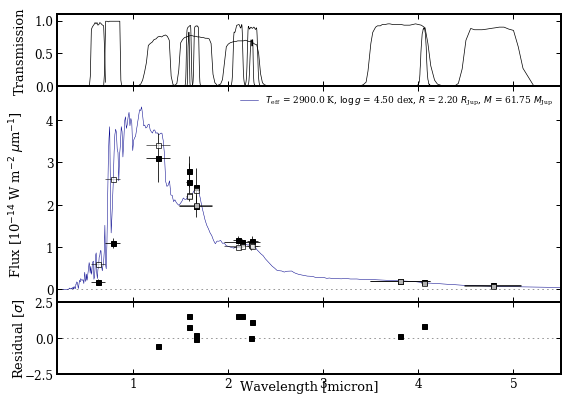

In [19]:
from IPython.display import Image
Image('spectrum.png') 